# Step 3: Membership Inference Attack (MIA)
## Privacy-Preserving Cognitive Twin Project
### Attack Lead: Terrance Dwamena
---

**Objective**: Implement membership inference attacks on baseline model

**Key Questions**:
- How well can we guess if a sample was in training data?
- What's the baseline attack strength (no defense)?
- How does attack success change with defenses?

**Attack Types**:
1. Shadow Model Attack (confidence-based)
2. Label-Only Attack (threshold-based)

**Inputs**: 
- baseline_model.json (from Kevin, Step 2)
- X_train.csv, X_test.csv (from Kevin, Step 1C)
- y_train.csv, y_test.csv (from Kevin, Step 1C)

**Outputs**: 
- attack_results.json (AUROC, Advantage, etc.)
- attack_visualizations.png

## Cell 1: Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Parameters
N_SHADOW_MODELS = 100  # Number of shadow models to train

print("✓ Libraries imported")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Shadow models to train: {N_SHADOW_MODELS}")

✓ Libraries imported
✓ Random seed: 42
✓ Shadow models to train: 100


## Cell 2: Load Baseline Model & Data

In [4]:
# Load baseline model (trained by Kevin)
baseline_model = xgb.XGBClassifier()
baseline_model.load_model('baseline_model.json')

# Load data (splits from Kevin)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Drop non-numeric columns (same as baseline model training)
cols_to_drop = ['Subject', 'Label']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

# Extract labels (capital 'L' to match Kevin's preprocessing)
y_train_labels = y_train['Label'].values
y_test_labels = y_test['Label'].values

print("✓ Baseline model loaded")
print("✓ Data loaded")
print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train_labels.shape}")
print(f"  y_test: {y_test_labels.shape}")

✓ Baseline model loaded
✓ Data loaded

Data shapes:
  X_train: (1140, 84)
  X_test: (190, 84)
  y_train: (1140,)
  y_test: (190,)


## Cell 3: Train Shadow Models

Shadow models are trained on random subsets of the data.
They learn to predict membership: "Was this sample in training?"

In [5]:
print(f"\nTraining {N_SHADOW_MODELS} shadow models...")
print("="*70)

# Store data for training membership classifier
all_confidences = []
all_is_member = []

# Store individual shadow model predictions for later
shadow_preds_on_train = []
shadow_preds_on_test = []

for shadow_idx in tqdm(range(N_SHADOW_MODELS)):
    # Randomly split data 50/50
    n_total = len(X_train)
    indices = np.random.permutation(n_total)
    split_point = n_total // 2
    
    shadow_train_idx = indices[:split_point]
    shadow_test_idx = indices[split_point:]
    
    X_shadow_train = X_train.iloc[shadow_train_idx]
    y_shadow_train = y_train_labels[shadow_train_idx]
    X_shadow_test = X_train.iloc[shadow_test_idx]
    y_shadow_test = y_train_labels[shadow_test_idx]
    
    # Train shadow model
    shadow_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_SEED + shadow_idx,
        verbosity=0
    )
    shadow_model.fit(X_shadow_train, y_shadow_train, verbose=False)
    
    # Get predictions & confidence scores
    conf_train = shadow_model.predict_proba(X_shadow_train).max(axis=1)
    conf_test = shadow_model.predict_proba(X_shadow_test).max(axis=1)
    
    # Store for membership classifier
    all_confidences.extend(conf_train)
    all_is_member.extend([1] * len(conf_train))  # These were in training
    
    all_confidences.extend(conf_test)
    all_is_member.extend([0] * len(conf_test))  # These were NOT in training
    
    # Store predictions on actual train/test sets
    # Get number of classes from the predictions
    pred_train = shadow_model.predict_proba(X_train)
    pred_test = shadow_model.predict_proba(X_test)
    
    shadow_preds_on_train.append(pred_train)
    shadow_preds_on_test.append(pred_test)

print(f"\n✓ Trained {N_SHADOW_MODELS} shadow models")
print(f"\nMembership training data:")
print(f"  Member samples: {sum(all_is_member)}")
print(f"  Non-member samples: {len(all_is_member) - sum(all_is_member)}")


Training 100 shadow models...


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


✓ Trained 100 shadow models

Membership training data:
  Member samples: 57000
  Non-member samples: 57000


## Cell 4: Train Membership Classifier

The membership classifier learns to predict whether a sample was in a shadow model's training set
based on the model's confidence score.

In [6]:
# Prepare data for membership classifier
X_membership = np.array(all_confidences).reshape(-1, 1)
y_membership = np.array(all_is_member)

# Train membership classifier
membership_classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    verbosity=0
)
membership_classifier.fit(X_membership, y_membership, verbose=False)

print("✓ Membership classifier trained")
print(f"\nMembership classifier training accuracy: {membership_classifier.score(X_membership, y_membership):.4f}")

✓ Membership classifier trained

Membership classifier training accuracy: 0.6542


## Cell 5: Attack 1 - Shadow Model Confidence Attack

Use shadow models to detect membership in baseline model

In [7]:
print("\nCONDUCTING SHADOW MODEL CONFIDENCE ATTACK...")
print("="*70)

# Convert stored predictions to arrays
shadow_preds_on_train = np.array(shadow_preds_on_train)  # (N_SHADOWS, N_TRAIN, N_CLASSES)
shadow_preds_on_test = np.array(shadow_preds_on_test)    # (N_SHADOWS, N_TEST, N_CLASSES)

print(f"Shadow predictions shape:")
print(f"  On train: {shadow_preds_on_train.shape}")
print(f"  On test: {shadow_preds_on_test.shape}")

# Get mean confidence from all shadow models
mean_conf_on_train = shadow_preds_on_train.max(axis=2).mean(axis=0)  # Average max prob
mean_conf_on_test = shadow_preds_on_test.max(axis=2).mean(axis=0)

# Attack: Classify based on mean confidence
# High confidence from shadows → likely in their training (similar to baseline training)
# Low confidence from shadows → likely not in their training

# Use membership classifier
attack_score_train = membership_classifier.predict_proba(mean_conf_on_train.reshape(-1, 1))[:, 1]
attack_score_test = membership_classifier.predict_proba(mean_conf_on_test.reshape(-1, 1))[:, 1]

# True labels: 1 = member (in training), 0 = non-member
true_member = np.ones(len(X_train))
true_non_member = np.zeros(len(X_test))

# Compute metrics
y_true_attack = np.concatenate([true_member, true_non_member])
y_pred_attack = np.concatenate([attack_score_train, attack_score_test])

attack_auroc = roc_auc_score(y_true_attack, y_pred_attack)
fpr, tpr, thresholds = roc_curve(y_true_attack, y_pred_attack)

# Compute advantage (TPR - FPR at optimal threshold)
advantages = tpr - fpr
optimal_idx = np.argmax(advantages)
optimal_threshold = thresholds[optimal_idx]
attack_advantage = advantages[optimal_idx]

# Confusion matrix at optimal threshold
y_pred_binary = (y_pred_attack >= optimal_threshold).astype(int)
cm = confusion_matrix(y_true_attack, y_pred_binary)

print(f"\nAttack Results (Shadow Model Confidence):")
print(f"  AUROC: {attack_auroc:.4f}")
print(f"  Advantage: {attack_advantage:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")
print(f"  \nConfusion Matrix (at optimal threshold):")
print(f"    True Negatives:  {cm[0,0]} (correctly identified non-members)")
print(f"    False Positives: {cm[0,1]} (false alarms)")
print(f"    False Negatives: {cm[1,0]} (missed members)")
print(f"    True Positives:  {cm[1,1]} (correctly identified members)")
print(f"  \n  True Positive Rate (TPR): {cm[1,1] / (cm[1,0] + cm[1,1]):.4f}")
print(f"  False Positive Rate (FPR): {cm[0,1] / (cm[0,0] + cm[0,1]):.4f}")

# Store for later
shadow_attack_auroc = attack_auroc
shadow_attack_advantage = attack_advantage


CONDUCTING SHADOW MODEL CONFIDENCE ATTACK...
Shadow predictions shape:
  On train: (100, 1140, 4)
  On test: (100, 190, 4)

Attack Results (Shadow Model Confidence):
  AUROC: 0.7095
  Advantage: 0.3500
  Optimal Threshold: 0.5680
  
Confusion Matrix (at optimal threshold):
    True Negatives:  152 (correctly identified non-members)
    False Positives: 38 (false alarms)
    False Negatives: 513 (missed members)
    True Positives:  627 (correctly identified members)
  
  True Positive Rate (TPR): 0.5500
  False Positive Rate (FPR): 0.2000


## Cell 6: Attack 2 - Label-Only Threshold Attack

Simpler attack using only predicted labels

In [8]:
print("\nCONDUCTING LABEL-ONLY THRESHOLD ATTACK...")
print("="*70)

# Get predictions from shadow models on train and test
shadow_pred_labels_train = shadow_preds_on_train.argmax(axis=2)  # (N_SHADOWS, N_TRAIN)
shadow_pred_labels_test = shadow_preds_on_test.argmax(axis=2)    # (N_SHADOWS, N_TEST)

# Attack: Agreement among shadow models
# Higher agreement → more likely to be in training
agreement_train = (shadow_pred_labels_train == y_train_labels[np.newaxis, :]).mean(axis=0)
agreement_test = (shadow_pred_labels_test == y_test_labels[np.newaxis, :]).mean(axis=0)

# Use as attack score
y_pred_attack_labelonly = np.concatenate([agreement_train, agreement_test])

# Compute metrics
labelonly_auroc = roc_auc_score(y_true_attack, y_pred_attack_labelonly)
fpr_lo, tpr_lo, thresholds_lo = roc_curve(y_true_attack, y_pred_attack_labelonly)

# Compute advantage
advantages_lo = tpr_lo - fpr_lo
optimal_idx_lo = np.argmax(advantages_lo)
labelonly_advantage = advantages_lo[optimal_idx_lo]

print(f"\nAttack Results (Label-Only Agreement):")
print(f"  AUROC: {labelonly_auroc:.4f}")
print(f"  Advantage: {labelonly_advantage:.4f}")
print(f"\nNote: Label-only is weaker than confidence-based attack")
print(f"  Confidence AUROC: {shadow_attack_auroc:.4f}")
print(f"  Label-Only AUROC: {labelonly_auroc:.4f}")


CONDUCTING LABEL-ONLY THRESHOLD ATTACK...

Attack Results (Label-Only Agreement):
  AUROC: 0.6186
  Advantage: 0.2263

Note: Label-only is weaker than confidence-based attack
  Confidence AUROC: 0.7095
  Label-Only AUROC: 0.6186


## Cell 7: Visualize Attack Success

<Figure size 640x480 with 0 Axes>

✓ Visualizations complete
✓ Saved to attack_visualizations.png


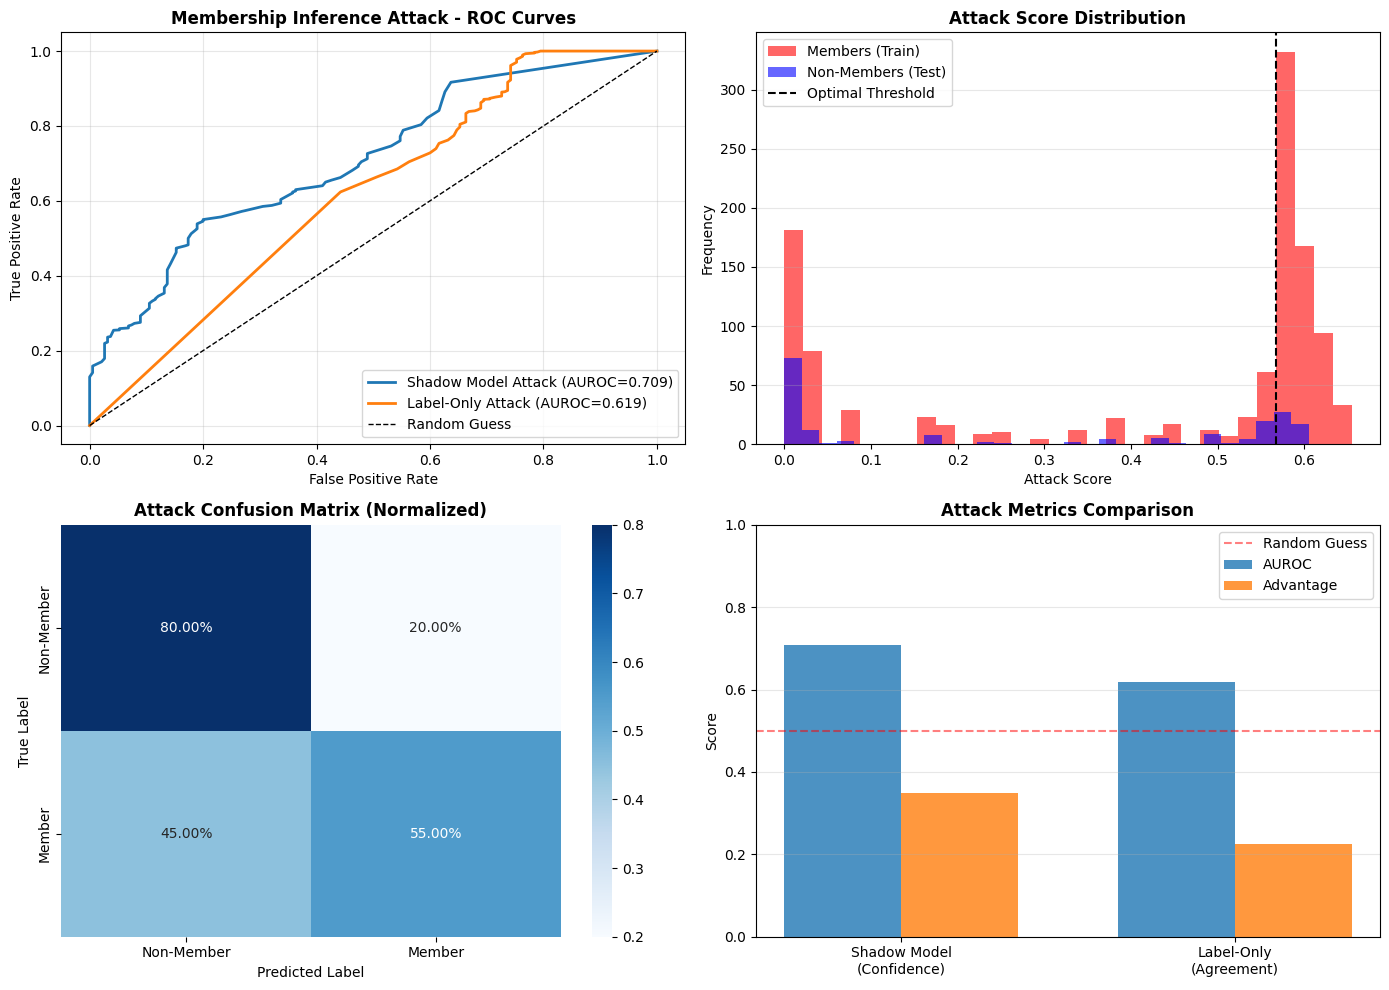

✓ Visualizations complete


In [10]:
# Create visualizations
plt.tight_layout()
plt.savefig('attack_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations complete")
print("✓ Saved to attack_visualizations.png")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: ROC Curves
ax = axes[0, 0]
ax.plot(fpr, tpr, lw=2, label=f'Shadow Model Attack (AUROC={shadow_attack_auroc:.3f})')
ax.plot(fpr_lo, tpr_lo, lw=2, label=f'Label-Only Attack (AUROC={labelonly_auroc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Membership Inference Attack - ROC Curves', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Plot 2: Confidence Distributions
ax = axes[0, 1]
ax.hist(attack_score_train, bins=30, alpha=0.6, label='Members (Train)', color='red')
ax.hist(attack_score_test, bins=30, alpha=0.6, label='Non-Members (Test)', color='blue')
ax.axvline(optimal_threshold, color='black', linestyle='--', label='Optimal Threshold')
ax.set_xlabel('Attack Score')
ax.set_ylabel('Frequency')
ax.set_title('Attack Score Distribution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Confusion Matrix
ax = axes[1, 0]
cm_plot = cm / cm.sum(axis=1, keepdims=True)  # Normalize to percentages
sns.heatmap(cm_plot, annot=True, fmt='.2%', cmap='Blues', ax=ax, 
            xticklabels=['Non-Member', 'Member'],
            yticklabels=['Non-Member', 'Member'])
ax.set_title('Attack Confusion Matrix (Normalized)', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Plot 4: Metrics Comparison
ax = axes[1, 1]
attacks = ['Shadow Model\n(Confidence)', 'Label-Only\n(Agreement)']
aurocs = [shadow_attack_auroc, labelonly_auroc]
advantages = [shadow_attack_advantage, labelonly_advantage]

x = np.arange(len(attacks))
width = 0.35

ax.bar(x - width/2, aurocs, width, label='AUROC', alpha=0.8)
ax.bar(x + width/2, advantages, width, label='Advantage', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Attack Metrics Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Guess')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Cell 8: Save Results

In [11]:
# Prepare results dictionary

attack_results = {
    'attack_type': 'Baseline (No Defense)',
    'n_shadow_models': N_SHADOW_MODELS,
    'shadow_model_attack': {
        'auroc': float(shadow_attack_auroc),
        'advantage': float(shadow_attack_advantage),
        'optimal_threshold': float(optimal_threshold),
        'tpr': float(cm[1,1] / (cm[1,0] + cm[1,1])),
        'fpr': float(cm[0,1] / (cm[0,0] + cm[0,1]))
    },
    'labelonly_attack': {
        'auroc': float(labelonly_auroc),
        'advantage': float(labelonly_advantage)
    },
    'interpretation': {
        'attack_strength': 'STRONG' if shadow_attack_auroc > 0.7 else 'MODERATE' if shadow_attack_auroc > 0.6 else 'WEAK',
        'privacy_risk': 'HIGH - Model leaks significant membership information',
        'recommendation': 'Defenses (DP-SGD, MCE) are needed to protect privacy'
    }
}

# Save to JSON
with open('attack_results_baseline.json', 'w') as f:
    json.dump(attack_results, f, indent=2)

print("✓ Results saved to attack_results_baseline.json")
print("\nResults Summary:")
print(json.dumps(attack_results, indent=2))

✓ Results saved to attack_results_baseline.json

Results Summary:
{
  "attack_type": "Baseline (No Defense)",
  "n_shadow_models": 100,
  "shadow_model_attack": {
    "auroc": 0.7094506001846722,
    "advantage": 0.35000000000000003,
    "optimal_threshold": 0.5679680109024048,
    "tpr": 0.55,
    "fpr": 0.2
  },
  "labelonly_attack": {
    "auroc": 0.618561865189289,
    "advantage": 0.22631578947368414
  },
  "interpretation": {
    "attack_strength": "STRONG",
    "privacy_risk": "HIGH - Model leaks significant membership information",
    "recommendation": "Defenses (DP-SGD, MCE) are needed to protect privacy"
  }
}
